In [237]:
import os 
import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import regex as re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime
from sklearn.svm import SVC
from random import sample

nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\conner.brew\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\conner.brew\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\conner.brew\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [238]:
#load in training data. We will use this as both train and test, and save 'test.json' for validation
data = pd.read_json('data/train/train.json').rename(columns = {'requester_received_pizza': 'target'})
drop_cols = [col for col in data.columns if 'retrieval' in col]
data = data.drop(columns=drop_cols)
drop_cols = ['giver_username_if_known', 'request_id', 'requester_username', 'post_was_edited']
data = data.drop(columns=drop_cols)
                 
#Change the boolean target variable to an int
data['target'] = data['target'].astype(int)
                 
y = data['target']
X = data.drop(columns=['target'])

#Get a rough idea of target baseline
baseline = round(sum(data['target']) / len(data['target']), 2)
print(f'Roughly {int(baseline * 100)}% of requests receive pizza.')



Roughly 25% of requests receive pizza.


In [239]:
def balance_sample(X, y):
    X_pos = [i for i in range(len(X)) if y[i] == 1]
    X_neg = sample([i for i in range(len(X)) if y[i] != 1], 994)

    y_pos = [i for i in range(len(y)) if y[i] == 1]
    y_neg = sample([i for i in range(len(y)) if y[i] != 1], 994)

    y = pd.concat([y.iloc[y_pos], y.iloc[y_neg]])
    X = pd.concat([X.iloc[X_pos], X.iloc[X_neg]])
    
    return X, y

def eval_model(X, clf, plot_importance = False):
    X = X.select_dtypes(np.number)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123, stratify=y)
    
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(f'CV Model Accuracy: {round(np.mean(scores), 4) * 100}%')
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    
    print('Out of Sample Performance:')
    print(metrics.confusion_matrix(yhat, y_test))
    print(metrics.classification_report(yhat, y_test))

    if plot_importance == True:
        importances = clf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
        feature_names = list(X.columns)
        forest_importances = pd.Series(importances, index=feature_names)

        fig, ax = plt.subplots(figsize=(10,10))
        forest_importances.plot.barh(yerr=std, ax=ax)
        ax.set_title("Feature importances using MDI")
        ax.set_ylabel("Mean decrease in impurity")
        fig.tight_layout()

    
def test_transformation(X, transformer):
    X = X.select_dtypes(np.number)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
    X_train = transformer.fit_transform(X_train)

    #Default randomforest with cross validation
    clf = RandomForestClassifier(bootstrap=True, max_depth=80,max_features=3,min_samples_leaf=3,min_samples_split=8,n_estimators=200)
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print(f'Model accuracy w {str(transformer)}: {round(np.mean(scores), 4) * 100}%')
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    print('Out of Sample Performance:')
    print(metrics.classification_report(yhat, y_test))
    print('-------------------------\n')

In [240]:
#X, y = balance_sample(X, y)

CV Model Accuracy: 73.95%
Out of Sample Performance:
[[932 273]
 [ 74  55]]
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      1205
           1       0.17      0.43      0.24       129

    accuracy                           0.74      1334
   macro avg       0.55      0.60      0.54      1334
weighted avg       0.85      0.74      0.78      1334



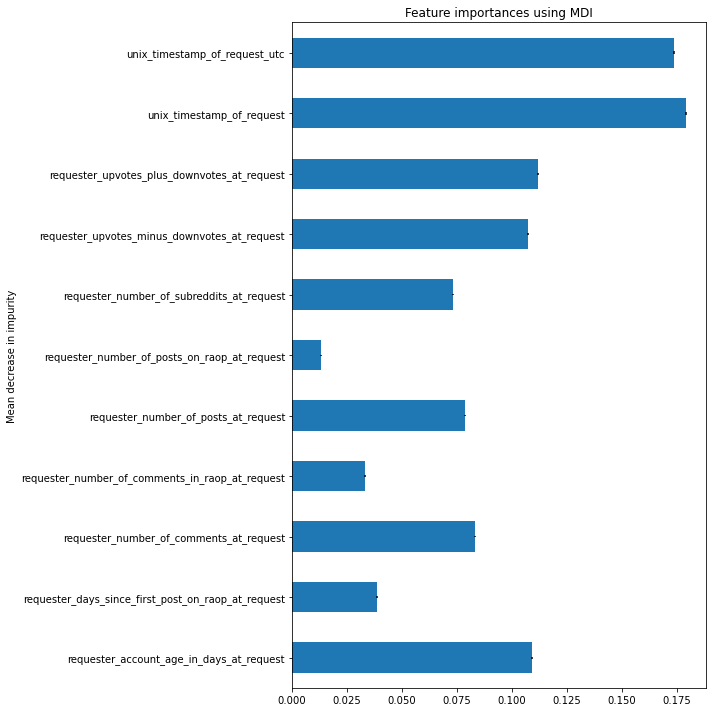

In [241]:
rf = RandomForestClassifier()
eval_model(X.copy(), rf, plot_importance = True)

In [242]:
transformers = [
    preprocessing.StandardScaler(),
    preprocessing.Normalizer(),
    preprocessing.MinMaxScaler(),
    preprocessing.MaxAbsScaler(),
    preprocessing.PowerTransformer(method = 'yeo-johnson')
]

for transformer in transformers:
    test_transformation(X.copy(), transformer)

Model accuracy w StandardScaler(): 75.17%
Out of Sample Performance:
              precision    recall  f1-score   support

           0       0.95      0.76      0.85      1257
           1       0.09      0.36      0.14        77

    accuracy                           0.74      1334
   macro avg       0.52      0.56      0.49      1334
weighted avg       0.90      0.74      0.80      1334

-------------------------

Model accuracy w Normalizer(): 75.39%
Out of Sample Performance:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      1334
           1       0.00      0.00      0.00         0

    accuracy                           0.75      1334
   macro avg       0.50      0.38      0.43      1334
weighted avg       1.00      0.75      0.86      1334

-------------------------



C:\Users\conner.brew\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model accuracy w MinMaxScaler(): 74.94%
Out of Sample Performance:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1134
           1       0.20      0.32      0.24       200

    accuracy                           0.70      1334
   macro avg       0.53      0.54      0.53      1334
weighted avg       0.76      0.70      0.73      1334

-------------------------

Model accuracy w MaxAbsScaler(): 75.2%
Out of Sample Performance:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1136
           1       0.19      0.31      0.24       198

    accuracy                           0.70      1334
   macro avg       0.53      0.54      0.52      1334
weighted avg       0.76      0.70      0.73      1334

-------------------------



C:\Users\conner.brew\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


Model accuracy w PowerTransformer(): 75.64999999999999%
Out of Sample Performance:
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      1266
           1       0.08      0.37      0.13        68

    accuracy                           0.74      1334
   macro avg       0.52      0.56      0.49      1334
weighted avg       0.91      0.74      0.81      1334

-------------------------



CV Model Accuracy: 75.72%
Out of Sample Performance:
[[960 284]
 [ 46  44]]
              precision    recall  f1-score   support

           0       0.95      0.77      0.85      1244
           1       0.13      0.49      0.21        90

    accuracy                           0.75      1334
   macro avg       0.54      0.63      0.53      1334
weighted avg       0.90      0.75      0.81      1334



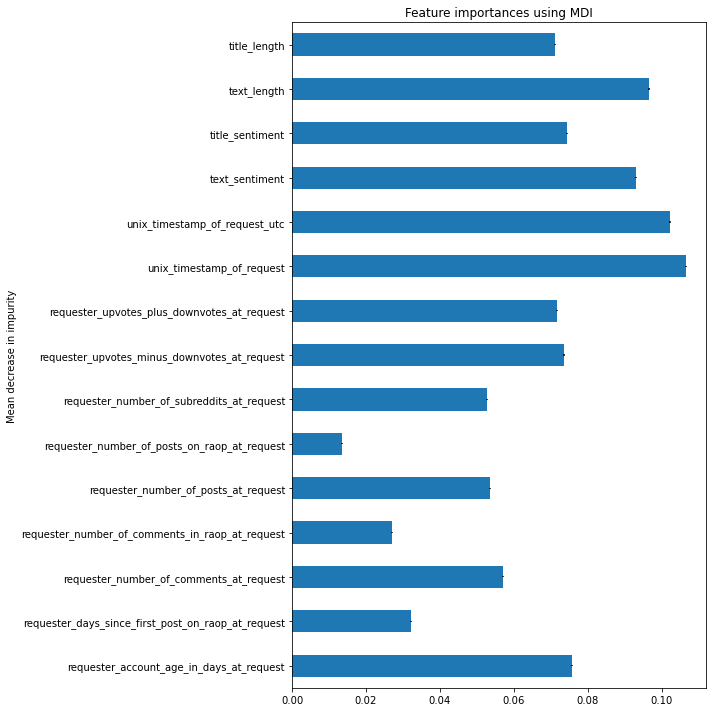

In [243]:
 def sentiment_analyze(X):
    sid = SentimentIntensityAnalyzer()
    sid_data = X.copy()
    
    #use inbuilt sid.polarity_scores to extract scores. Read on for the results
    text_analyzed = X['request_text_edit_aware'].apply(lambda request_text: sid.polarity_scores(request_text))

    #We break the dict generated above and pull only column 'compound'
    sid_data['text_sentiment']  = text_analyzed.apply(lambda s : s['compound'])

    #use inbuilt sid.polarity_scores to extract scores. Read on for the results
    title_analyzed = X['request_title'].apply(lambda request_title: sid.polarity_scores(request_title))

    #We break the dict generated above and pull only column 'compound'
    sid_data['title_sentiment']  = title_analyzed.apply(lambda s : s['compound'])

    sid_data['text_length']=data['request_text_edit_aware'].apply(lambda s: len(nltk.word_tokenize(s)))
    sid_data['title_length']=data['request_title'].apply(lambda s: len(nltk.word_tokenize(s)))
    
    return sid_data

eval_model(sentiment_analyze(X.copy()), rf, plot_importance=True)

In [244]:
def vectorize_text(X):
    documents = []

    stop_words = set(stopwords.words('english'))
    stemmer = WordNetLemmatizer()

    for doc in X['request_text_edit_aware']:
        # Remove all the special characters
        document = re.sub(r'\W', ' ', str(doc))    
        # remove all single characters
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)    
        # Remove single characters from the start
        document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)     
        # Substituting multiple spaces with single space
        document = re.sub(r'\s+', ' ', document, flags=re.I)    
        # Removing prefixed 'b'
        document = re.sub(r'^b\s+', '', document) 
        # Converting to Lowercase
        document = document.lower()    
        #drop stops
        document = document.split()
        document = [word for word in document if word not in stop_words]    
        #lemmatize
        document = [stemmer.lemmatize(word) for word in document]
        document = ' '.join(document)
        documents.append(document)
        
    vectorizer = CountVectorizer(max_features=100, min_df=10, max_df=0.7, stop_words=stopwords.words('english'))
    vec = vectorizer.fit_transform(documents).toarray()
    
    return vec

In [245]:
def count_vectorize(X):
    vec_data = pd.merge(X, pd.DataFrame(vectorize_text(X.copy())), left_index=True, right_index=True)
    return vec_data

eval_model(count_vectorize(X.copy()), rf)

CV Model Accuracy: 75.42999999999999%
Out of Sample Performance:
[[989 296]
 [ 17  32]]
              precision    recall  f1-score   support

           0       0.98      0.77      0.86      1285
           1       0.10      0.65      0.17        49

    accuracy                           0.77      1334
   macro avg       0.54      0.71      0.52      1334
weighted avg       0.95      0.77      0.84      1334



In [246]:
def tfidf_vec(X):

    tfidfconverter = TfidfTransformer()
    tfidf_request = tfidfconverter.fit_transform(vectorize_text(X.copy())).toarray()

    tfidf_data = pd.merge(X, pd.DataFrame(tfidf_request), left_index=True, right_index=True)
    
    return tfidf_data
    
eval_model(tfidf_vec(X.copy()), rf)


CV Model Accuracy: 75.39%
Out of Sample Performance:
[[996 302]
 [ 10  26]]
              precision    recall  f1-score   support

           0       0.99      0.77      0.86      1298
           1       0.08      0.72      0.14        36

    accuracy                           0.77      1334
   macro avg       0.53      0.74      0.50      1334
weighted avg       0.97      0.77      0.85      1334



In [247]:
# Column labels that have text fields
def nb_features(X):
    text_columns = ['request_text', 'request_text_edit_aware', 'request_title']
    
    nb_data = X.copy()
    new_features = []
    # Looping thru each text field
    for field in text_columns:
        # Getting corpus for current field
        corpus = X[field]

        # Defining vectorizer and getting 
        vec = CountVectorizer()
        matrix = vec.fit_transform(corpus).toarray()

        # Naive bayes classifier fitted
        clf = MultinomialNB()
        clf.fit(matrix, y)

        # Getting coefficients for each word in corpus
        coefs = clf.coef_

        # Initializing list for new feature
        text_weights = []

        # Looping thru each text, multiply coefficient weights by frequencies, add to new feature vector
        for row in matrix:
            weight = (coefs * row).sum()
            text_weights.append(weight)

        # Making copy of X data and adding our new feature
        nb_data[field] = text_weights

    return nb_data, clf

#nb_data, nb_clf = nb_features(X.copy())
#eval_model(nb_data, plot_importance=True)


CV Model Accuracy: 74.69%
Out of Sample Performance:
[[940 287]
 [ 66  41]]
              precision    recall  f1-score   support

           0       0.93      0.77      0.84      1227
           1       0.12      0.38      0.19       107

    accuracy                           0.74      1334
   macro avg       0.53      0.57      0.52      1334
weighted avg       0.87      0.74      0.79      1334



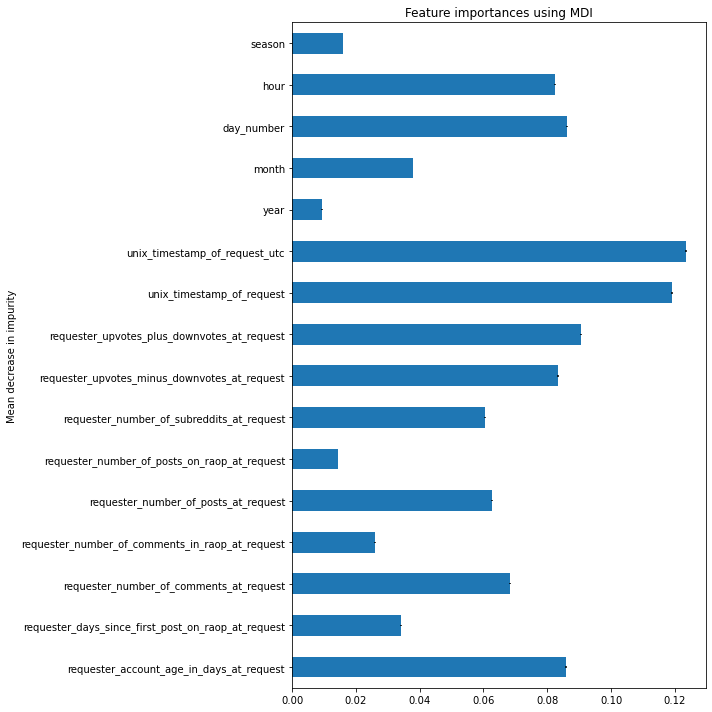

In [248]:
# Adding timestamp column to dataframe
def determine_season(row):
    month = row.month
    if month < 4:
        return 0
    if month < 7:
        return 1
    if month < 10:
        return 2
    return 3

def apply_time(X):
    X['date_hour'] = X.apply(lambda row: datetime.fromtimestamp(row.unix_timestamp_of_request).strftime('%Y-%m-%d-%H'), 
                                   axis = 1)

    # Function to determine season


    # Creating Adding New columns for year, month, day_number, hour, and season
    X['year'] = pd.DataFrame(X.apply(lambda row: int(row.date_hour.split('-')[0]), axis = 1))
    X['month'] = pd.DataFrame(X.apply(lambda row: int(row.date_hour.split('-')[1]), axis = 1))
    X['day_number'] = pd.DataFrame(X.apply(lambda row: int(row.date_hour.split('-')[2]), axis = 1))
    X['hour'] =  pd.DataFrame(X.apply(lambda row: int(row.date_hour.split('-')[3]), axis = 1))
    X['season'] = pd.DataFrame(X.apply(lambda row: determine_season(row), axis = 1))
    
    return X

eval_model(apply_time(X.copy()), rf, plot_importance=True)

## Final Data Engineering

In [249]:
model_data = apply_time(X)
model_data = sentiment_analyze(model_data)
model_data = count_vectorize(model_data)

eval_model(model_data, rf)

CV Model Accuracy: 75.61%
Out of Sample Performance:
[[996 302]
 [ 10  26]]
              precision    recall  f1-score   support

           0       0.99      0.77      0.86      1298
           1       0.08      0.72      0.14        36

    accuracy                           0.77      1334
   macro avg       0.53      0.74      0.50      1334
weighted avg       0.97      0.77      0.85      1334



In [250]:
models = [RandomForestClassifier(), LogisticRegression(), SVC()]
for model in models:
    print(model)
    eval_model(model_data, model)

RandomForestClassifier()
CV Model Accuracy: 75.76%
Out of Sample Performance:
[[991 297]
 [ 15  31]]
              precision    recall  f1-score   support

           0       0.99      0.77      0.86      1288
           1       0.09      0.67      0.17        46

    accuracy                           0.77      1334
   macro avg       0.54      0.72      0.51      1334
weighted avg       0.95      0.77      0.84      1334

LogisticRegression()
CV Model Accuracy: 75.39%
Out of Sample Performance:
[[1006  328]
 [   0    0]]
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      1334
           1       0.00      0.00      0.00         0

    accuracy                           0.75      1334
   macro avg       0.50      0.38      0.43      1334
weighted avg       1.00      0.75      0.86      1334

SVC()


C:\Users\conner.brew\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV Model Accuracy: 75.39%
Out of Sample Performance:
[[1006  328]
 [   0    0]]
              precision    recall  f1-score   support

           0       1.00      0.75      0.86      1334
           1       0.00      0.00      0.00         0

    accuracy                           0.75      1334
   macro avg       0.50      0.38      0.43      1334
weighted avg       1.00      0.75      0.86      1334



C:\Users\conner.brew\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [251]:
model_data = model_data.select_dtypes(np.number)
X_train, X_test, y_train, y_test = train_test_split(model_data, y, test_size=0.33, random_state=42, stratify=y)

from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
grid_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   35.2s finished


{'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': True}


In [252]:
best_params = grid_search.best_params_

optimized_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    bootstrap=best_params['n_estimators']
)

eval_model(model_data, optimized_rf)

CV Model Accuracy: 76.2%
Out of Sample Performance:
[[998 300]
 [  8  28]]
              precision    recall  f1-score   support

           0       0.99      0.77      0.87      1298
           1       0.09      0.78      0.15        36

    accuracy                           0.77      1334
   macro avg       0.54      0.77      0.51      1334
weighted avg       0.97      0.77      0.85      1334



In [253]:
final_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    bootstrap=best_params['n_estimators']
)

final_rf.fit(model_data, y)

test_data = pd.read_json('data/test/test.json')
test_data = apply_time(test_data)
test_data = sentiment_analyze(test_data)
test_data = count_vectorize(test_data)

test_data = test_data.select_dtypes(np.number)

In [254]:
yhat = final_rf.predict(test_data)

In [255]:
submission = pd.DataFrame(data = {
    'request_id': list(pd.read_json('data/test/test.json')['request_id']),
    'requester_received_pizza': yhat
})

submission.to_csv('submission.csv')

In [256]:
submission

,request_id,requester_received_pizza
0,t3_i8iy4,0
1,t3_1mfqi0,0
2,t3_lclka,0
3,t3_1jdgdj,0
4,t3_t2qt4,0
...,...,...
1626,t3_knttk,0
1627,t3_11wza2,0
1628,t3_iwbsf,0
1629,t3_nys7g,0
